In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, add, Cropping2D, ReLU, BatchNormalization, Lambda, PReLU
from tensorflow.keras.layers import Concatenate, Reshape, MaxPooling1D, Cropping1D, ZeroPadding1D, Flatten
from tensorflow.keras.layers import AveragePooling2D, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, OrderedEnqueuer
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations
from tensorflow.keras.backend import expand_dims

import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)
#tf.keras.backend.set_floatx('float16')

In [2]:
height_x = 120
width_x = 133
channels = 3
n_slices = 27
shape_x = (n_slices, height_x, width_x, channels)
width_y = 27
shape_y = (height_x, width_y, channels)

data_num = 1
data_dir = f"../../datasets/dataset_0{data_num}/quarter/"
name = "recurent-v2"

activation = 'relu'
regularizer = regularizers.l1(1e-9)
dropout_ratio = 0.25

batch_size = 1
epochs = 20
learning_rate = 1e-4

workers = 4
maxQueue = 8

In [3]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=4,
                    n_channels=1, n_classes=1, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'X', filename)
                image_x = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'Y', filename)
                image_y = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    Y.append(image_y)
                    X_images = []
                    for i in range(27):
                        #print(f'X cat: {image_x[:,i:,:].shape} | y cat: {image_y[:,:i+1,:].shape}\n')
                        temp = np.concatenate((image_x[:,i:,:], image_y[:,:i,:]), axis=1)
                        X_images.append(temp)
                    X_images = np.array(X_images)
                    X.append(X_images)
                    
        Y = (1./255) * np.array(Y)
        #Y = np.swapaxes(Y,1,2)
        X = (1./255) * np.array(X)

        #X_series = []
        #for i in range(27):
        #    #print(f'X cat: {X[:,:,i:,:].shape} | y cat: {Y[:,:,:i+1,:].shape}\n')
        #    temp = np.concatenate((X[:,:,i:,:], Y[:,:,:i,:]), axis=2)
        #    #print(f'cat: {temp.shape}\n')
        #    X_series.append(temp)

        X = np.array(X)
        Y = np.swapaxes(Y,1,2)

        return X, Y

In [4]:
def block(input, kernels):
    x = TimeDistributed(Conv2D(kernels, kernel_size=1, strides=(1,1), padding='same'))(input)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(ReLU())(x)

    x = TimeDistributed(Conv2D(kernels, kernel_size=3, strides=(1,1), padding='same'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(ReLU())(x)

    x = TimeDistributed(Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x_0 = TimeDistributed(Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same'))(input)
    x_0 = TimeDistributed(BatchNormalization())(x_0)

    x = add([x,x_0])
    x = TimeDistributed(ReLU())(x)
    return x

input_x = Input(shape=shape_x)
x = Lambda(lambda x: x[:,:,:,-120:,:])(input_x)

x = TimeDistributed(Conv2D(64, kernel_size=7, strides=(1,1)))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(ReLU())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(3,3), strides=(2,2)))(x)

for i in range(4):
    for j in range(3):
        x = block(x, 64 * (2**i))
    x = TimeDistributed(MaxPooling2D())(x)

x = TimeDistributed(AveragePooling2D())(x)
x = TimeDistributed(Flatten())(x)
x = TimeDistributed(Dense(360, activation='relu', activity_regularizer=regularizer))(x)

x = TimeDistributed(Reshape((120,3)))(x)

autoencoder = Model(input_x, x)
autoencoder.summary()

Model: &quot;model&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27, 120, 133 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 27, 120, 120, 0           input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 27, 114, 114, 9472        lambda[0][0]                     
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 27, 114, 114, 256         time_distributed[0][0]           
____________________________________________________________________________________

In [5]:
adam = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [6]:
files = os.listdir(data_dir+'X')
gen_loader = DataGenerator(files, batch_size=batch_size)
autoencoder.fit(gen_loader, epochs=epochs, steps_per_epoch=1000,
            use_multiprocessing=True, workers=workers, shuffle=True)

Epoch 1/150
  71/1000 [=&gt;............................] - ETA: 6:58 - loss: 0.2077Process Keras_worker_ForkPoolWorker-3:
Process Keras_worker_ForkPoolWorker-1:
Process Keras_worker_ForkPoolWorker-2:
Process Keras_worker_ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 315, in _bootstrap
    self.run()
  File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 315, in _bootstrap
    self.run()
  File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 315, in _bootstrap
    self.run()
  File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 315, in _bootstrap
    self.run()
  File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process

KeyboardInterrupt: 

In [1]:
autoencoder.save_weights('saved_models/'+'recurrent-timedis')

NameError: name &#39;autoencoder&#39; is not defined

In [ ]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)[:,0,:]
image_true = np.concatinate((image_x, image_y_true), axis=1)

#for i in range(27):
y = autoencoder(image_x)
print(y.shape)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)

(1, 27, 120, 133, 3)
(1, 27, 120, 3)


&lt;matplotlib.image.AxesImage at 0x7fbe25ba2e20&gt;

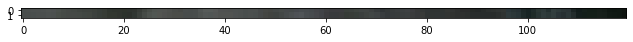

In [77]:
loader = DataGenerator(os.listdir(data_dir+'X'), batch_size=1)
#enqueuer = OrderedEnqueuer(loader, use_multiprocessing=True, shuffle=True)
#enqueuer.start(workers=workers, max_queue_size=8)
#output_generator = enqueuer.get()
#img_x, img_y = next(output_generator)
img_x, img_y = loader.__getitem__(1)
print(img_x.shape)
print(img_y.shape)
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(img_y[0,:2,:,:])